In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy



#CMI smooth version 1 takes in two data vectors, and creates bxb grid
def CMI_smooth_v1(x,y,b):
    
    if len(x)==len(y):
        sizeOfVector = len(x)
        
        #Distribution formula in 1 dimension
        P = [1/(i+1) for i in range(b)]

        x_p = ((x-min(x))/(max(x)-min(x)))*b #Let x' be the vector x rescaled on the interval [0,b]
        y_p = ((y-min(y))/(max(y)-min(y)))*b #Let y' be the vector y rescaled on the interval [0,b]

        #Take the ceiling of x_p and y_p
        for i in range(0,sizeOfVector):
            x_p[i] = numpy.ceil(x_p[i])
            y_p[i] = numpy.ceil(y_p[i])

        #Cumulative Density function in 2D
        PXY= [[0 for i in range(b)] for i in range(b)]
        
        for j in range (1,b+1):
            for i in range (1, b+1): #For every upper right corner
                #print("(" + str(i) + "," + str(j) + ")") #print points      
                distribution = 0
                for k in range (0, sizeOfVector): #For every point data given
                    if (x_p[k]== i) and (y_p[k] == j): #If the point of the data matches the upper right hand corner
                        #print("(" + str(x_p[k]) + "," + str(y_p[k]) + ")")
                        distribution = distribution +1 #Then add 1 to the distribution counter
                        #print(distribution)
                PXY[i-1][j-1] = distribution/sizeOfVector

        #Calculate Cumulative Entropy of X and Y (Note CE(X) = CE(Y) by symmetry)
        CEXoY = 0
        for i in range (b):
            CEXoY = CEXoY - P[i]*numpy.log(P[i])

        #Calculate CE(X,Y)
        CEXY =0 
        for i in range (1, b):
            for j in range (1 ,b):
                if (PXY[i][j] != 0):
                    CEXY = CEXY - PXY[i][j]*numpy.log(PXY[i][j])

        #Caculate Cumulative Mutual Information
        CMI = (max(y) - numpy.mean(y))*CEXoY + (max(x)- numpy.mean(x))*CEXoY- CEXY

        return CMI
        
        

In [11]:
#CMI smooth version 2 takes in two data vectors, and creates n_grid
def CMI_smooth_v2(x,y,b):
    if len(x) == len(y):
        sizeOfVector = len(x)
        x_o = numpy.sort(x)
        y_o = numpy.sort(y)

        #Distribution function in 1 Dimension
        P = [1/(i+1) for i in range(sizeOfVector)]

        #Intervals in x and y
        xinterval =[(x_o[i+1] - x_o[i]) for i in range(sizeOfVector-1)]
        yinterval =[(y_o[i+1] - y_o[i]) for i in range(sizeOfVector-1)]

        #print(x_o)
        #print(xinterval)

        #Calculate Cumulative Entropy of X and Y
        CEX = 0
        CEY = 0
        for i in range(len(xinterval)):
            CEX = CEX - xinterval[i]*P[i]*numpy.log(P[i])
            CEY = CEY - yinterval[i]*P[i]*numpy.log(P[i])

        #print(CEX)
        #print(CEY)


        x_p = ((x-min(x))/(max(x)-min(x)))*b #Let x' be the vector x rescaled on the interval [0,b]
        y_p = ((y-min(y))/(max(y)-min(y)))*b #Let y' be the vector y rescaled on the interval [0,b]

        #Take the ceiling of x_p and y_p
        for i in range(0,sizeOfVector):
            x_p[i] = numpy.ceil(x_p[i])
            y_p[i] = numpy.ceil(y_p[i])

        #Cumulative Density function in 2D
        PXY= [[0 for i in range(b)] for i in range(b)]

        #Keep a counter of every point at every upper right corner
        for j in range (1,b+1):
            for i in range (1, b+1): #For every upper right corner
                #print("(" + str(i) + "," + str(j) + ")") #print points      
                distribution = 0
                for k in range (0, sizeOfVector): #For every point data given
                    if (x_p[k]== i) and (y_p[k] == j): #If the point of the data matches the upper right hand corner
                        #print("(" + str(x_p[k]) + "," + str(y_p[k]) + ")")
                        distribution = distribution +1 #Then add 1 to the distribution counter
                        #print(distribution)
                PXY[i-1][j-1] = distribution/sizeOfVector

        #Calculate CE(X,Y)
        CEXY =0 
        for i in range (1, b):
            for j in range (1 ,b):
                if (PXY[i][j] != 0):
                    CEXY = CEXY - PXY[i][j]*numpy.log(PXY[i][j])

        #print(CEXY)

        #Caculate Cumulative Mutual Information
        CMI = (max(y) - numpy.mean(y))*CEX + (max(x)- numpy.mean(x))*CEY- CEXY

        return(CMI)


In [12]:
#Generate two N-elment Gaussian random vectors with coorrelation rho
def xy_cor(N,rho,truncate = True):
    xx = numpy.array([0, 1])
    yy = numpy.array([0, 1])
    means = [0, 1]  
    stds = [0.5, 0.5]
    covs = [[stds[0]**2, stds[0]*stds[1]*rho], 
        [stds[0]*stds[1]*rho, stds[1]**2]] 
    m = numpy.random.multivariate_normal(means, covs, N).T
    x = (m[0] - numpy.mean(m[0]))/numpy.std(m[0])
    y = (m[1] - numpy.mean(m[1]))/numpy.std(m[1])
    if (truncate == True):
        x = (x - numpy.min(x))/(numpy.max(x) - numpy.min(x))
        y = (y - numpy.min(y))/(numpy.max(y) - numpy.min(y))
        thres = 3
        for i in range(N):
            if x[i] > thres:
                x[i] = thres
            if x[i] < -thres:
                x[i] = -thres
            if y[i] > thres:
                y[i] = thres
            if y[i] < -thres:
                y[i] = -thres  
    return (x, y)

In [13]:
#Generate correlated random data for incremental values of the correlation between x and y with grid size M by M

N = 20 #Length of vector x and y
M = 20 #Creating an M by M grid
inst = 1

corrs = numpy.arange(-1,1,0.05)
T = len(corrs)
CMI_1_aver =  numpy.zeros(T, dtype= "float_")
CMI_2_aver = numpy.zeros(T, dtype= "float_")

for t in range(T):
    CMI_1_vals = numpy.zeros(inst, dtype = "float_")
    CMI_2_vals = numpy.zeros(inst, dtype = "float_")
    for k in range(inst):
        (x,y) = xy_cor(N, corrs[t], truncate = False)
        CMI_1_vals[k] = CMI_smooth_v1(x,y,M)
        CMI_2_vals[k] = CMI_smooth_v2(x,y,M)    
    CMI_1_aver[t] = numpy.mean(CMI_1_vals)
    CMI_2_aver[t] = numpy.mean(CMI_2_vals)
        

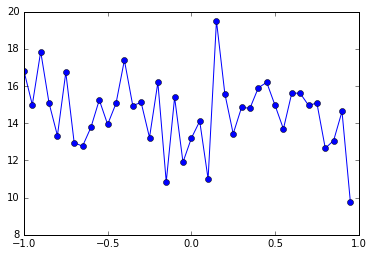

In [14]:
#Graph CMI with first approach
plt.plot(corrs, CMI_1_aver, 'bo-')

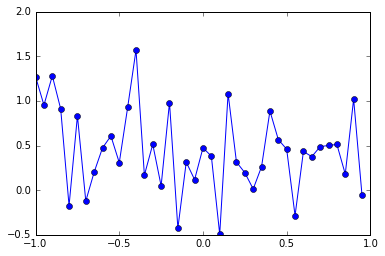

In [15]:
#Graph CMI with second approach
plt.plot(corrs, CMI_2_aver, 'bo-')